# RESNET Demo

# Content
* [Model Architecture](#Model-Architecture)
* [Model Optimizations](#Model-Optimizations)
* [Performance](#Performance-Overview)
* [DEMO](#DEMO)

## Image Classification
* Classify different images into different categories to achieve the smallest classification error. Image classification is a supervised learning problem: define a set of target classes (objects to identify in images), and train a model to recognize them using labeled example photos.
![image_classification.png](./img/image_classification.png)


## Model Architecture

### VGG Neural Networks
* VGG stands for Visual Geometry Group; it is a standard deep Convolutional Neural Network (CNN) architecture with multiple layers. The “deep” refers to the number of layers with VGG-16 or VGG-19 consisting of 16 and 19 convolutional layers. 
* The VGG architecture is the basis of ground-breaking object recognition models. Developed as a deep neural network, the VGGNet also surpasses baselines on many tasks and datasets beyond ImageNet. Moreover, it is now still one of the most popular image recognition architectures.


![resnet.png](./img/resnet.png)
### Deep Residual Learning for Image Recognition(ResNet)
Deep residual networks like the popular ResNet-50 model is a convolutional neural network (CNN) that is 50 layers deep. A Residual Neural Network (ResNet) is an Artificial Neural Network (ANN) of a kind that stacks residual(shown as below image) blocks on top of each other to form a network.

A residual network is a stack of many residual blocks. Regular design, like VGG: each residual block has two 3x3 conv. 
The Network is divided into stages: the first block of each stage halves the resolution (with stride-2 conv) and doubles the number of channels

![residual.png](./img/residual.png)

## Model Optimizations
## HPO with SDA (Smart Democratization Advisor)



SDA config

```
Parameters for SDA auto optimization:
- resnet_size:[18, 34, 50] #number of residual blocks 
- num_filters:[2,4,8,16,32,64] #number filters of convolution layer
- kernel_size:[1,3,5,7,9] #number kernel size of convolution layer
- label_smoothing:0.05~0.5 #parameter for optimizer
- momentum:0.6~0.99 #parameter for optimizer
- weight_decay:1e-5~5e-5 #weight decay coefficiant for l2 regularization
- base_lr:0.01~0.2 #base learning rate for optimizer
metrics:
- name: accuracy
  objective: maximize
- name: training_time
  strategy: optimize
  objective: minimize
```


request suggestions from SDA

```python
suggestion = self.conn.experiments(self.experiment.id).suggestions().create()
```


## Model related optimization
### Add attention block
* The attention mechanism is generated by imitating human attention. When human are looking at an image, some parts of the image  will attract human attention, while others may be ignored. This is equivalent to adding a visual weight to the entire image. Attention mechanisms can be divided into channel attention and spatial attention. In simple terms, the attention mechanism is to multiply each channel or the entire spatial feature map by a weight to represent their importance.
* Add attention block to 34 layers ResNet model delivered 2.55x speedup, and 8.34x speedup over baseline. The implemented attention block layer to ResNet model is a middle layer between two residual blocks, so that the output of the middle layer becomes outputs = (1 + masks) * maps. This optimization with 1% top1 accuracy regression (0.751 vs. 0.759)

### Disable BF16
* MLCommons training v1.0 code optimized on CPX and with BF16 enabled by default, while ICX doesn't support BF16
* Disable BF16 for 50 layers model delivered 4.52x speedup, and 14.79x speedup over baseline. Top1 accuracy is 0.757

## Profling Proof
* After disable BF16, the cpu increase average 25% to 45%, so per iteration time decreased
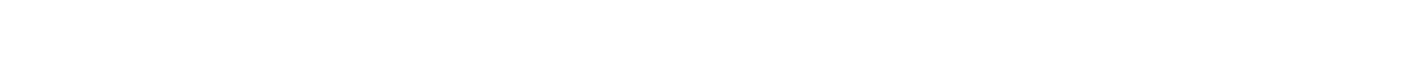

![cpu_baseline1.png](./img/cpu_baseline1.png)
<center>Four nodes ResNet50 baseline</center>

![cpu_bf16.png](./img/cpu_bf16.png)
<center>Four nodes ResNet50 Disable BF16</center>

## Performance Overview

Distributed training with HW scaling delivered 3.27x speedup from 1 node to 4 nodes.

Add attention block to 34 layers ResNet model delivered 2.55x speedup, and 8.34x speedup over baseline.
* With 1% top1 accuracy regression (0.751 vs. 0.759)

Disable BF16 for 50 layers model delivered 4.52x speedup, and 14.79x speedup over baseline.
* Top1 accuracy is 0.757

![resnet_training_perf.png](./img/resnet_training_perf.png)
![resnet_training_speedup.png](./img/resnet_training_speedup.png)

# DEMO
* [Environment Setup](#Environment-setup)
* [Train](#Train)

## Environment setup
``` bash
# Setup ENV
git clone https://github.com/intel/e2eAIOK.git
git submodule update --init --recursive
cd e2eAIOK
python3 scripts/start_e2eaiok_docker.py -b tensorflow -w ${host0} ${host1} ${host2} ${host3} --proxy ""
```

## Workflow Prepare

* Below manual setup will be wrapped with AIDK-workflow in v0.3

``` bash
# prepare model codes
cd modelzoo/resnet
bash patch_resnet.patch

# Download Dataset
```
The TF ResNet50-v1.5 model is trained with ImageNet 1K, a popular image classification dataset from ILSVRC challenge. The dataset can be downloaded from:

http://image-net.org/download-images

More dataset requirements can be found at:

https://github.com/mlperf/training/tree/master/image_classification#3-datasetenvironment


Notes: ResNet training is based on ImageNet1K dataset, we evaluated Top-1 Accuracy with stock model (based on MLPerf submission) at ImageNet1K dataset, and final Top-1 Accuracy is 0.757

public reference paper: https://arxiv.org/abs/1512.03385

## Train

In [5]:
# Train (single node)
! cd /home/vmagent/app/e2eaiok/; python -u run_e2eaiok.py --data_path /home/vmagent/app/dataset/resnet --model_name resnet --conf /home/vmagent/app/e2eaiok/tests/cicd/conf/e2eaiok_defaults_resnet_example.conf --no_sigopt


***    Best Trained Model    ***
  Model Type: resnet
  Model Saved Path: /home/vmagent/app/e2eaiok/result/159938443786e7f5538c8ba256dbfefa
  Sigopt Experiment id is None
  === Result Metrics ===
    accuracy: 1.0
    training_time: 0.010071277618408203
2022-10-31 17:54:48,376 - E2EAIOK - INFO - Above info is history record of this model
2022-10-31 17:54:48,376 - E2EAIOK.SDA - INFO - ### Ready to submit current task  ###
2022-10-31 17:54:48,376 - E2EAIOK.SDA - INFO - Model Advisor created
2022-10-31 17:54:48,376 - E2EAIOK.SDA - INFO - model parameter initialized
2022-10-31 17:54:48,376 - E2EAIOK.SDA - INFO - start to launch training
2022-10-31 17:54:48,376 - sigopt - INFO - training launch command: /opt/intel/oneapi/intelpython/latest/envs/tensorflow/bin//horovodrun -n 2 -H localhost:2 HOROVOD_CPU_OPERATIONS=CCL CCL_ATL_TRANSPORT=mpi /opt/intel/oneapi/intelpython/latest/envs/tensorflow/bin//python -u /home/vmagent/app/e2eaiok/modelzoo/resnet/mlperf_resnet/imagenet_main.py '123456' --l

[0]<stderr>:INFO:tensorflow:Calling model_fn.
[1]<stderr>:INFO:tensorflow:Calling model_fn.
[0]<stderr>:/opt/intel/oneapi/intelpython/latest/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
[0]<stderr>:  warnings.warn('`tf.layers.conv2d` is deprecated and '
[1]<stderr>:/opt/intel/oneapi/intelpython/latest/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
[1]<stderr>:  warnings.warn('`tf.layers.conv2d` is deprecated and '
[0]<stderr>:/opt/intel/oneapi/intelpython/latest/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will

[0]<stderr>:INFO:tensorflow:Done calling model_fn.
[0]<stderr>:INFO:tensorflow:Create CheckpointSaverHook.
[1]<stderr>:INFO:tensorflow:Done calling model_fn.
[1]<stderr>:INFO:tensorflow:Create CheckpointSaverHook.
[0]<stderr>:WARNING:tensorflow:From /opt/intel/oneapi/intelpython/latest/envs/tensorflow/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/util.py:96: DistributedIteratorV1.initialize (from tensorflow.python.distribute.input_lib) is deprecated and will be removed in a future version.
[0]<stderr>:Instructions for updating:
[0]<stderr>:Use the iterator's `initializer` property instead.
[1]<stderr>:WARNING:tensorflow:From /opt/intel/oneapi/intelpython/latest/envs/tensorflow/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/util.py:96: DistributedIteratorV1.initialize (from tensorflow.python.distribute.input_lib) is deprecated and will be removed in a future version.
[1]<stderr>:Instructions for updating:
[1]<stderr>:Use the iterator's `initializer

2022-10-31 17:56:09,346 - sigopt - INFO - Training completed based in sigopt suggestion, took 80.96904230117798 secs
2022-10-31 17:56:09,347 - E2EAIOK.SDA - INFO - training script completed

We found the best model! Here is the model explaination

***    Best Trained Model    ***
  Model Type: resnet
  Model Saved Path: /home/vmagent/app/e2eaiok/result/159938443786e7f5538c8ba256dbfefa
  Sigopt Experiment id is None
  === Result Metrics ===
    accuracy: 1.0
    training_time: 80.96904230117798
